In [393]:
import os

import sklearn
from sklearn.preprocessing import StandardScaler as ss
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import math as m

In [394]:
np.set_printoptions(suppress=True, precision=5)

In [395]:
df = pd.read_csv('insurance.csv')

In [396]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [397]:
y = df['charges']
df = df.drop(columns='charges')

In [398]:
num_features = list(df.select_dtypes(exclude='object').columns)
cat_features = list(df.select_dtypes(include='object').columns)
print(num_features)
print(cat_features)

['age', 'bmi', 'children']
['sex', 'smoker', 'region']


## 1. Подготовка данных

1. проверить наличие пропусков и выбросов

In [399]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [400]:
q1, q3 = y.quantile([0.25, 0.75])
iqr = q3 - q1
inds = set(y[(y < q1 - 1.5 * iqr) | (y > q3 + 1.5 * iqr)].index)

In [401]:
len(inds), len(df)

(139, 1338)

2. привести категориальные признаки к числовым

In [402]:
X = pd.get_dummies(df, columns=cat_features, drop_first=True, dtype=int)
X[num_features] = ss().fit_transform(X[num_features].values)

In [403]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, random_state=42)

In [404]:
X_train = pd.read_csv('insurance_test.csv')
X_test = pd.read_csv('insurance_train.csv')

In [405]:
y_train = np.array(X_train['charges'])
X_train = pd.get_dummies(X_train.drop(columns='charges'), columns=cat_features, drop_first=True, dtype=int)
X_train[num_features] = ss().fit_transform(X_train[num_features])

y_test = np.array(X_test['charges'])
X_test = pd.get_dummies(X_test.drop(columns='charges'), columns=cat_features, drop_first=True, dtype=int)
X_test[num_features] = ss().fit_transform(X_test[num_features])

3. вычислить парные корреляции признаков

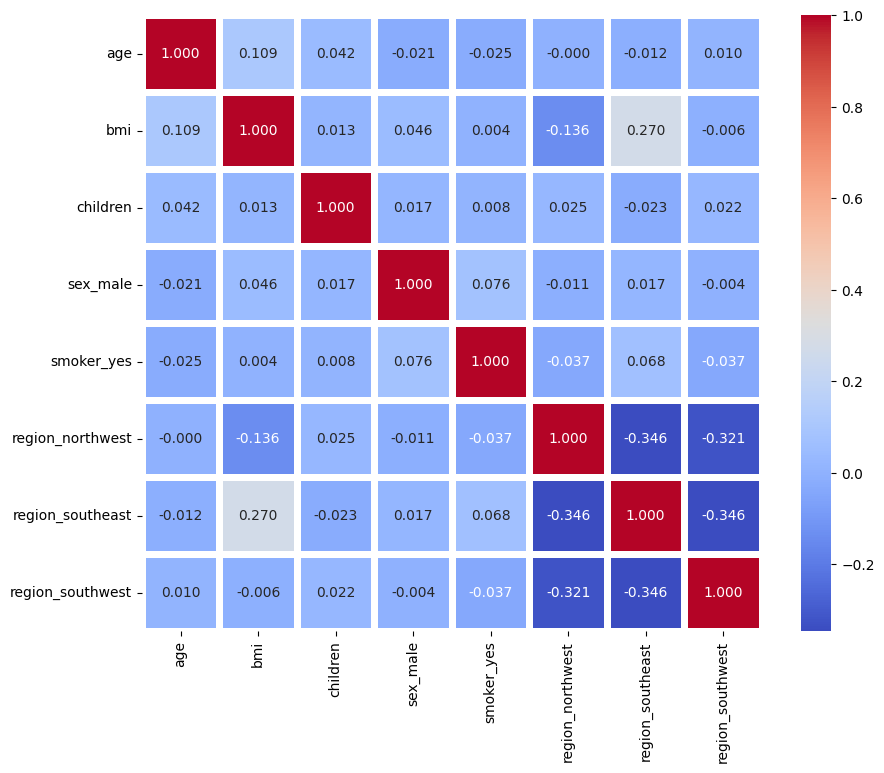

In [406]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    X.corr(),
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    linewidths=5,
    cbar=True
)
plt.show()

## 2. Многомерная линейная регрессия

In [407]:
X_train = np.concat([np.ones(shape=(X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concat([np.ones(shape=(X_test.shape[0], 1)), X_test], axis=1)

1. аналитически (реализовать самому)

In [408]:
def solve_analytical(X, y):
    return np.array(np.linalg.inv(X.T @ X) @ X.T @ y)

In [409]:
w_opt_1 = solve_analytical(X_train, y_train)
w_opt_1

array([ 8838.53932,  3651.60107,  2033.09763,   562.70007,    41.62017,
       23991.48376,  -425.42789,  -976.43614,  -840.10624])

In [410]:
def gradient_descent(X, y, learning_rate=3e-3, max_iter=1000):
    w = np.random.normal(size=X.shape[1])
    for i in tqdm(range(max_iter)):
        gradient = X.T @ (X @ w - y)
        if np.linalg.norm(gradient) < 1e-8:
            return w
        w -= learning_rate * gradient
    return np.array(w)

In [411]:
w_opt_2 = gradient_descent(X_train, y_train, learning_rate=3e-4)

100%|██████████| 1000/1000 [00:00<00:00, 135971.21it/s]


In [412]:
w_opt_2

array([ 8838.53872,  3651.60107,  2033.09758,   562.70006,    41.62023,
       23991.48378,  -425.4272 ,  -976.43543,  -840.10554])

## 3. Добавление регуляризации

1. аналитически

In [413]:
def get_analytical_ridge(X, y, reg_coef=1):
    I = np.eye(X.shape[1])
    I[0, 0] = 0
    return np.linalg.inv(X.T @ X + reg_coef * I) @ X.T @ y

In [414]:
w_opt_1_ridge = get_analytical_ridge(X_train, y_train, reg_coef=10)
w_opt_1_ridge

array([ 8984.92762,  3599.87072,  1987.34999,   565.41758,   106.17271,
       22531.08674,  -358.53748,  -730.227  ,  -732.96448])

In [415]:
def gradient_descent_ridge(X, y, learning_rate=3e-3, reg_coef=1, max_iter=1000):
    w = np.random.normal(size=X.shape[1])
    for i in tqdm(range(max_iter)):
        gradient = X.T @ (X @ w - y)
        penalty = reg_coef * w
        penalty[0] = 0
        gradient += penalty
        if np.linalg.norm(gradient) < 1e-8:
            return w
        w -= learning_rate * gradient
    return np.array(w)

In [416]:
w_opt_2_ridge = gradient_descent_ridge(X_train, y_train, learning_rate=3e-4, reg_coef=10)
w_opt_2_ridge

100%|██████████| 1000/1000 [00:00<00:00, 123300.23it/s]


array([ 8984.92757,  3599.87072,  1987.34998,   565.41758,   106.17272,
       22531.08675,  -358.53743,  -730.22695,  -732.96442])

In [418]:
def mse(X, y, w):
    return 1 / X.shape[0] * (X @ w - y).T @ (X @ w - y)

def rmse(X, y, w):
    return m.sqrt(mse(X, y, w))

In [419]:
w_constant = np.full(shape=X_train.shape[1], fill_value=y_train.mean())
w_constant

array([12992.43766, 12992.43766, 12992.43766, 12992.43766, 12992.43766,
       12992.43766, 12992.43766, 12992.43766, 12992.43766])

In [423]:
print(f'MSE for constant(mean): {mse(X_test, y_test, w_constant):.2f}')
print(f'RMSE for constant(mean): {rmse(X_test, y_test, w_constant):.2f}')
print()
print(f'MSE for linear regression(analytic): {mse(X_test, y_test, w_opt_1):.2f}')
print(f'RMSE for linear regression(analytic): {rmse(X_test, y_test, w_opt_1):.2f}')
print()
print(f'MSE for linear regression(gradient descent): {mse(X_test, y_test, w_opt_2):.2f}')
print(f'RMSE for linear regression(gradient descent): {rmse(X_test, y_test, w_opt_2):.2f}')
print()
print(f'MSE for ridge(analytic): {mse(X_test, y_test, w_opt_1_ridge):.2f}')
print(f'RMSE for ridge(analytic): {rmse(X_test, y_test, w_opt_1_ridge):.2f}')
print()
print(f'MSE for linear regression(gradient descent): {mse(X_test, y_test, w_opt_2_ridge):.2f}')
print(f'RMSE for linear regression(gradient descent): {rmse(X_test, y_test, w_opt_2_ridge):.2f}')

MSE for constant(mean): 904878565.33
RMSE for constant(mean): 30081.20

MSE for linear regression(analytic): 44713393.24
RMSE for linear regression(analytic): 6686.81

MSE for linear regression(gradient descent): 44713393.31
RMSE for linear regression(gradient descent): 6686.81

MSE for ridge(analytic): 44839743.17
RMSE for ridge(analytic): 6696.25

MSE for linear regression(gradient descent): 44839743.18
RMSE for linear regression(gradient descent): 6696.25
